In [1]:
import re
import json
import numpy as np
import datetime
import time
from nltk.stem import PorterStemmer
from os import listdir

class Regs: 
    specialChars = '' 
    digits = '' 
    singleChars = ''
    multipleWhiteSpaces = ''
    stopWords = list()
stopWords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours","ers", "yourself", "yourselves", "he","isnt","cant" "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "wasnt", "were", "be", "been", "being", "have", "havent", "has", "had", "having", "do", "does", "doesnt", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
ps = PorterStemmer()

#Precompile regexes for better performance
def compileRegexes():
    regexes = Regs()
    regexes.specialChars = re.compile('[^\w\s]')
    regexes.digits = re.compile('\d')
    regexes.singleChars = re.compile('\s.\s')
    regexes.multipleWhiteSpaces = re.compile('[ ]{2,}')
    for sw in stopWords:
        exp = '\\b' + sw + '+\W'
        regexes.stopWords.append(re.compile(exp))
    return(regexes)

#Format the index into string with length 7
def formatIndex(index):
    i = str(index)
    while len(i) < 7:
        i = "0" + i
    return(i)

#Gather the texts from the source, based on starting index, amount of article and class
#=> returns array of texts and array of classes
def gatherTexts(startingIndex, amountOfArticles, includeClasses):
    if len(includeClasses) < 1:
        print("There must be at least 1 class. eg: [0,1,2]")
    
    #Create two arrays, which will be returned from this function
    texts = []
    types = []
    
    #Get data for class 0 => in our project it is FINANCE
    if 0 in includeClasses:
        articles = listdir("DATA/Finance")
        nArticles = len(articles)
        #check if there are enough articles for the input paramteres
        if (nArticles > startingIndex + amountOfArticles) :
            for ind in range(startingIndex, startingIndex + amountOfArticles):
                with open("DATA/Finance/news_" + formatIndex(ind) + ".json", encoding="utf8") as json_data:
                    texts.append(json.load(json_data)["text"])
                    types.append("0")   

    #Get data for class 1 => in our project it is SPORT
    if 1 in includeClasses:
        articles = listdir("DATA/Sports")
        nArticles = len(articles)
        #check if there are enough articles for the input paramteres
        if (nArticles > startingIndex + amountOfArticles) :
            for ind in range(startingIndex, startingIndex + amountOfArticles):
                with open("DATA/Sports/news_" + formatIndex(ind) + ".json", encoding="utf8") as json_data:
                    texts.append(json.load(json_data)["text"])
                    types.append("1")   
                    
    #Get data for class 2 => in our project it is TECHNOLOGY
    if 2 in includeClasses:
        articles = listdir("DATA/Technology")
        nArticles = len(articles)
        #check if there are enough articles for the input paramteres
        if (nArticles > startingIndex + amountOfArticles) :
            for ind in range(startingIndex, startingIndex + amountOfArticles):
                with open("DATA/Technology/news_" + formatIndex(ind) + ".json", encoding="utf8") as json_data:
                    texts.append(json.load(json_data)["text"])
                    types.append("2")   
                    
    #Get data for class 3 => in our project it is ENTERTAINMENT
    if 3 in includeClasses:
        articles = listdir("DATA/Entertainment")
        nArticles = len(articles)
        #check if there are enough articles for the input paramteres
        if (nArticles > startingIndex + amountOfArticles) :
            for ind in range(startingIndex, startingIndex + amountOfArticles):
                with open("DATA/Entertainment/news_" + formatIndex(ind) + ".json", encoding="utf8") as json_data:
                    texts.append(json.load(json_data)["text"])
                    types.append("3") 
                    
    #if not (regexes is None):
    #    print("doing preprocess stage1")
    #    for j, text in enumerate(texts, start=0):
    #        texts[j] = preprocessStageOne(text, regexes)
                    
    return {'texts':texts, 'types':types}

def preprocessTexts(texts,types, regexes, usePorterStemmer = 0, removeUnfrequent = 0, removeFrequent = 0):    
    articles = []
    for index, text in enumerate(texts, start=0):
        if(text):
            articles.append(preprocessArticle(text,regexes,usePorterStemmer))
        if( index % 250 == 0):
            print("Preprocessed texts:",index)
        
    #create one array fromm all articles
    words = []
    words = [item for sublist in articles for item in sublist]
    #remove duplicate values from words list
    words = list(set(words))
    words = sorted(words)
    wordsDictionary = dict((v, i) for i, v in enumerate(words))
    
    articleWords = np.zeros((len(articles), len(words) + 1))
    for index, article in enumerate(articles, start=0):
        articleWords[index, 0 ] = types[index] 
        for j, word in enumerate(article, start=0):
            if word != '':
                articleWords[index, wordsDictionary[word] + 1] = 1   
                
    #Remove words with occurance = removeUnfrequent
    if removeUnfrequent >= 1:    
        indexes = []
        for word in wordsDictionary:
            if(sum(articleWords[:,wordsDictionary[word]]) > removeUnfrequent):
                indexes.append(wordsDictionary[word])
        ind = np.array(indexes)
        words = np.array(words)
        words = words[ind].tolist()
        articleWords = articleWords[:,np.insert(ind + 1, 0,0, axis=0)]
    
    #Remove words, which are the most frequent => TOP removeFrequent will be removed
    if removeFrequent > 0:
        usage = np.zeros(len(words)+1)
        for i in range(1, len(words)+1):
            usage[i] = sum(articleWords[:,i])
        for i in range(0, removeFrequent):
            words = np.delete(words,usage.tolist().index(max(usage)),0)
            articleWords = np.delete(articleWords, usage.tolist().index(max(usage)),1)
            usage = np.delete(usage,usage.tolist().index(max(usage)),0)
            
    return{'articleWords':articleWords, 'words':words}


#Create matrix containg all Phi values
#returns array(nClasses x amountOfWords)
def createPhiMatrix(articleWords, includeClasses):
    numberOfClasses = len(includeClasses)
    Y = np.zeros((numberOfClasses, articleWords.shape[1]))
    
    sumClasses = np.zeros((numberOfClasses))
    #number of rows clasified to first / second group
    for c, index in enumerate(includeClasses, start = 0):
        sumClasses[index] = float(len(articleWords[articleWords[:,0] == c,0]))

    #Laplace => alfa = 1
    alfa = 1

    #calcualting Phi_{y=0} and Phi_{y=1}
    for j in range(0, numberOfClasses):
        Y[j,0] = (sumClasses[j] + alfa) / float(articleWords.shape[0] + numberOfClasses * alfa)

    for j in range(1, articleWords.shape[1]):
        #calcualting Phi_{j|y=0} and Phi_{j|y=1}
        for k in range(0, numberOfClasses):
            Y[k,j] = (np.sum(articleWords[articleWords[:,0]==includeClasses[k],j]) + alfa) / (sumClasses[k] + numberOfClasses * alfa)
    
    return(Y)
    
#Preprocess the article with the precompiled regexes, and optional stemmer 
#=> returns the text splitted into array of words
def preprocessArticle(text, regexes, usePorterStemmer):
    text = preprocessStageOne(text, regexes)
    if usePorterStemmer == 1:
        splitted = text.split()
        for index, word in enumerate(splitted, start=0):
            splitted[index] = ps.stem(word)
        return splitted
    return(text.split())

def preprocessStageOne(text, regexes):
    text = text.lower()
    #new lines
    text = text.replace('\n', ' ')
    text = text.replace('_', ' ')
    #special characters
    text = re.sub(regexes.specialChars, ' ', text)
    #digits
    text = re.sub(regexes.digits, '', text)
    #stopwords
    for sw in regexes.stopWords:
        text = re.sub(sw , '', text)
    #single characters (ex donald j trump => donald trump)
    text = re.sub(regexes.singleChars, ' ', text)
    #multiple white spaces
    text = re.sub(regexes.multipleWhiteSpaces, ' ', text)
    return text

#Make prediction based on 
def predict(phiMatrix, text,words, regexes, usePorterStemmer):
    nClasses = phiMatrix.shape[0]
    Y = phiMatrix
    textPorcessed = preprocessArticle(text,regexes,usePorterStemmer)
    testArticleWords = np.zeros((1, len(words)))
    for k, word in enumerate(textPorcessed, start=0):
            if word in words:
                testArticleWords[0, words.index(word)] = 1

    P = np.zeros(nClasses)
    for j in range(0, nClasses):
        P[j] = np.log(Y[j,0]) + ((np.log(np.array(Y[j,1:]*testArticleWords)[testArticleWords == 1]))).sum() + ((np.log(np.array((1 - Y[j,1:])*(testArticleWords - 1)*-1)[testArticleWords == 0]))).sum()

    classPossibilities = np.zeros(4)
    for i in range(0,phiMatrix.shape[0]):
        classPossibilities[i] = 1 / (sum(np.exp(P-P[i])))
    
    return(np.argmax(classPossibilities))

print("Done")
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M"))

Done
2019-03-22 19:06


In [4]:
rawTexts =  gatherTexts(1,500,np.array([0,1,2,3]))
regs = compileRegexes()
preprocessedTexts = preprocessTexts(rawTexts["texts"],rawTexts["types"],regs)
phi = createPhiMatrix(preprocessedTexts["articleWords"],np.array([0,1,2,3]))
with open("DATA/Sport/news_0002100.json", encoding="utf8") as json_data:
    #print(index)
    testtext = json.load(json_data)["text"]
    start = time.time()
    print(predict(phi,testtext,preprocessedTexts["words"],regs,0))
    end = time.time()
    print(end-start)

1
0.015621185302734375


In [89]:


def generateTarget(amount):
    target = np.zeros(4*amount)
    for ind in range(amount, 2*amount):
        target[ind] = 1
    for ind in range(2*amount, 3*amount):
        target[ind] = 2
    for ind in range(3*amount, 4*amount):
        target[ind] = 3
    return(target)
    
    
#preprocessedTexts = preprocessTexts(rawTexts["texts"],rawTexts["types"],regs)

#preprocessedTexts["words"][np.where(np.sum(preprocessedTexts["articleWords"][:,1:], axis=0) == max(np.sum(preprocessedTexts["articleWords"][:,1:], axis=0)))[0][0]]


Text(0.5, 1.0, 'Top 50 tokens in sport tweets')

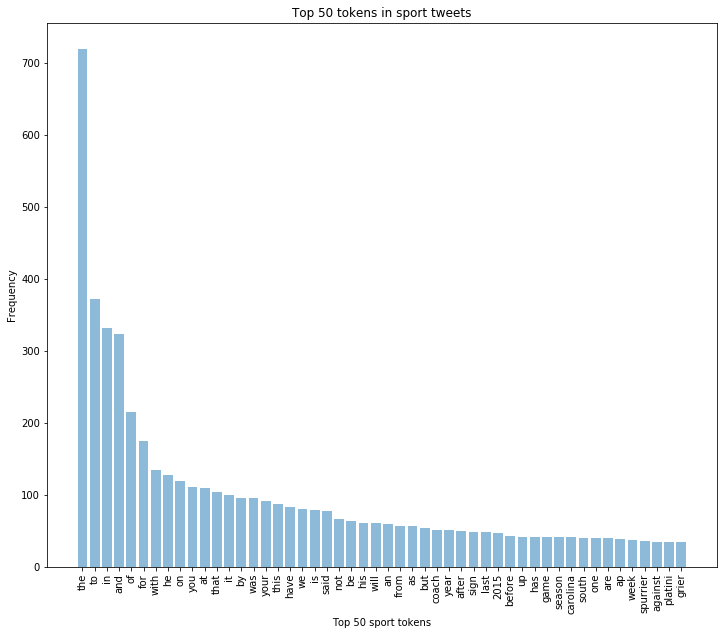

In [142]:
import matplotlib.pyplot as plt
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='sport', ascending=False)['sport'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='sport', ascending=False)['sport'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 sport tokens')
plt.title('Top 50 tokens in sport tweets')

In [141]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

regs = compileRegexes()
rawTexts =  gatherTexts(1,50,np.array([0,1,2,3]))

target = generateTarget(50)

cvec = CountVectorizer()
cvec.fit(rawTexts["texts"])

len(cvec.get_feature_names())

document_matrix = cvec.transform(np.array(rawTexts["texts"]))

fin_doc_matrix = cvec.transform(np.array(rawTexts["texts"])[target == 0])
spo_doc_matrix = cvec.transform(np.array(rawTexts["texts"])[target == 1])
tech_doc_matrix = cvec.transform(np.array(rawTexts["texts"])[target == 2])
ent_doc_matrix = cvec.transform(np.array(rawTexts["texts"])[target == 3])
fin_tf = np.sum(fin_doc_matrix,axis=0)
spo_tf = np.sum(spo_doc_matrix,axis=0)
tech_tf = np.sum(tech_doc_matrix,axis=0)
ent_tf = np.sum(ent_doc_matrix,axis=0)
fin = np.squeeze(np.asarray(fin_tf))
spo = np.squeeze(np.asarray(spo_tf))
tech = np.squeeze(np.asarray(tech_tf))
ent = np.squeeze(np.asarray(ent_tf))
term_freq_df = pd.DataFrame([fin,spo,tech,ent],columns=cvec.get_feature_names()).transpose()

term_freq_df.columns = ['finance', 'sport', 'technology', 'entertainment']
term_freq_df['total'] = term_freq_df['finance'] + term_freq_df['sport'] + term_freq_df['technology'] + term_freq_df['entertainment']
term_freq_df.sort_values(by='total', ascending=False).iloc[:15]

,finance,sport,technology,entertainment,total
the,1203,719,1156,929,4007
and,661,323,672,477,2133
to,754,372,589,377,2092
of,587,215,608,391,1801
in,490,331,408,411,1640
for,274,175,275,168,892
that,238,104,198,164,704
on,223,119,196,154,692
is,229,79,224,126,658
it,177,100,145,153,575


In [135]:
generateTarget(5)

array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 3., 3.,
       3., 3., 3.])

In [93]:
#np.where(np.sum(preprocessedTexts["articleWords"][:,1:], axis=0) == max(np.sum(preprocessedTexts["articleWords"][:,1:], axis=0)))[0]
#rawTexts
r = np.sum(document_matrix[0:40].toarray(),axis=0)

rr = np.sum(r,axis=0)


fin_doc_matrix = cvec.transform(np.array(rawTexts["texts"])[target == 0])
spo_doc_matrix = cvec.transform(np.array(rawTexts["texts"])[target == 1])
tech_doc_matrix = cvec.transform(np.array(rawTexts["texts"])[target == 2])
ent_doc_matrix = cvec.transform(np.array(rawTexts["texts"])[target == 3])
fin_tf = np.sum(fin_doc_matrix,axis=0)
spo_tf = np.sum(spo_doc_matrix,axis=0)
tech_tf = np.sum(tech_doc_matrix,axis=0)
ent_tf = np.sum(ent_doc_matrix,axis=0)
fin = np.squeeze(np.asarray(neg_tf))
spo = np.squeeze(np.asarray(pos_tf))
tech = np.squeeze(np.asarray(neg_tf))
ent = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([fin,spo,tech,ent],columns=cvec.get_feature_names()).transpose()

term_freq_df.columns = ['finance', 'sport', 'technology', 'entertainment']
term_freq_df['total'] = term_freq_df['finance'] + term_freq_df['sport'] + term_freq_df['technology'] + term_freq_df['entertainment']
term_freq_df.sort_values(by='total', ascending=False).iloc[:15]

AssertionError: 39320 columns passed, passed data had 3922 columns

In [103]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

rawTexts =  gatherTexts(1,50,np.array([0,1,2,3]))

target = generateTarget(50)

cvec = CountVectorizer()
cvec.fit(rawTexts["texts"])

len(cvec.get_feature_names())

document_matrix = cvec.transform(np.array(rawTexts["texts"]))

print(len(rawTexts["texts"]))


fin_doc_matrix = cvec.transform(np.array(rawTexts["texts"])[target == 0])
spo_doc_matrix = cvec.transform(np.array(rawTexts["texts"])[target == 1])
tech_doc_matrix = cvec.transform(np.array(rawTexts["texts"])[target == 2])
ent_doc_matrix = cvec.transform(np.array(rawTexts["texts"])[target == 3])
fin_tf = np.sum(fin_doc_matrix,axis=0)
spo_tf = np.sum(spo_doc_matrix,axis=0)
tech_tf = np.sum(tech_doc_matrix,axis=0)
ent_tf = np.sum(ent_doc_matrix,axis=0)
fin = np.squeeze(np.asarray(neg_tf))
spo = np.squeeze(np.asarray(spo_tf))
tech = np.squeeze(np.asarray(neg_tf))
ent = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([fin,spo,tech,ent],columns=cvec.get_feature_names()).transpose()


200


In [56]:
#print(preprocessedTexts["articleWords"])
rawTexts =  gatherTexts(1,50,np.array([0,1,2,3]))
#regs = compileRegexes()
preprocessedTexts = preprocessTexts(rawTexts["texts"],rawTexts["types"],regs)
#for i in np.array([0,1]):
    #print(np.mean(np.sum(preprocessedTexts["articleWords"][:,np.insert(np.array(np.sum(preprocessedTexts["articleWords"][preprocessedTexts["articleWords"][:,0]==i,1:], axis=0) != 0),0, False)][preprocessedTexts["articleWords"][:,0]==i,:], axis=0)))
    #print(np.sum(np.sum(preprocessedTexts["articleWords"][:,np.insert(np.array(np.sum(preprocessedTexts["articleWords"][preprocessedTexts["articleWords"][:,0]==i,1:], axis=0) != 0),0, False)][preprocessedTexts["articleWords"][:,0]==i,:], axis=0) == 1))
    #print(np.sum(np.sum(preprocessedTexts["articleWords"][:,np.insert(np.array(np.sum(preprocessedTexts["articleWords"][preprocessedTexts["articleWords"][:,0]==i,1:], axis=0) != 0),0, False)][preprocessedTexts["articleWords"][:,0]==i,:], axis=0) == 2))
    #print(np.mean(np.sum(preprocessedTexts["articleWords"][preprocessedTexts["articleWords"][:,0]==i,1:], axis=1)))

articleWords = preprocessedTexts["articleWords"]
#print(articleWords)

wordsOfGrous0 = np.sum(articleWords[articleWords[:,0] == 0,1:], axis=0)
wordsOfGrous1 = np.sum(articleWords[articleWords[:,0] == 1,1:], axis=0)

print(np.array((np.where( np.logical_and( wordsOfGrous0 > 0, wordsOfGrous1 > 0 ) ))).size)

1230


In [27]:
with open("DATA/Finance/news_0002010.json", encoding="utf8") as json_data:
    #print(index)
    testtext = json.load(json_data)["text"]
    start = time.time()
    print(predict(phi,testtext,preprocessedTexts["words"],regs,0))
    end = time.time()
    print(end-start)

NameError: name 'phi' is not defined

In [81]:
#print(preprocessedTexts["articleWords"])
rawTexts =  gatherTexts(1,100,np.array([1]))
regs = compileRegexes()
preprocessedTexts = preprocessTexts(rawTexts["texts"],rawTexts["types"],regs)
print(np.mean(np.sum(preprocessedTexts["articleWords"][preprocessedTexts["articleWords"][:,0]==1,1:], axis=0)))
print(np.mean(np.sum(preprocessedTexts["articleWords"][preprocessedTexts["articleWords"][:,0]==1,1:], axis=1)))

2.5194274028629855
98.56


In [57]:
def createPropertiesOfTrainingSet(startIndex, endIndex, usePorterStemmer = 0, removeUnfrequent = 0, removeFrequent = 0):
    #STEPS:
    #---1. Gather texts from all groups
    #---2. Preprocess them
    #---3. Create properties:
    #------- Average number of words in the texts for each group
    #------- Average texts where each word 
    
    print("Starting the method for creating properties...")
    #Needed variables:    
    regs = compileRegexes()
    
    #Get and preprocess texts 
    print("Starting the gathering of texts from " + str(startIndex) + " to " + str(endIndex) + "...")
    start = time.time()
    rawTexts =  gatherTexts(startIndex,endIndex,np.array([0,1,2,3]), null)
    end = time.time()
    print("Gathering finished in " + str(end-start) + " ms")
    print("Starting the preprocess...")
    start = time.time()
    preprocessedTexts = preprocessTexts(rawTexts["texts"],rawTexts["types"],regs, usePorterStemmer, removeUnfrequent, removeFrequent)
    end = time.time()
    print("Preprocessment finished in " + str(end-start) + " ms")
    
    print("Starting the properties calculation for each group...")
    start = time.time()
    averageAmountOfWords = np.zeros(4)
    averageUsageOfWords = np.zeros(4)
    amountOfRareWords1 = np.zeros(4)
    amountOfRareWords2 = np.zeros(4)
    totalAmountOfWords = np.zeros(4)
    
    articleWords = preprocessedTexts["articleWords"]
    
    for i in np.array([0,1,2,3]):        
        averageUsageOfWords[i] = np.mean(np.sum(articleWords[:,np.insert(np.array(np.sum(articleWords[articleWords[:,0]==i,1:], axis=0) != 0),0, False)][articleWords[:,0]==i,:], axis=0))
        averageAmountOfWords[i] = np.mean(np.sum(articleWords[articleWords[:,0]==i,1:], axis=1))
        amountOfRareWords1[i] = np.sum(np.sum(articleWords[:,np.insert(np.array(np.sum(articleWords[articleWords[:,0]==i,1:], axis=0) != 0),0, False)][articleWords[:,0]==i,:], axis=0) == 1)
        amountOfRareWords2[i] = np.sum(np.sum(articleWords[:,np.insert(np.array(np.sum(articleWords[articleWords[:,0]==i,1:], axis=0) != 0),0, False)][articleWords[:,0]==i,:], axis=0) == 2)
        totalAmountOfWords[i] = len(np.sum(articleWords[:,np.insert(np.array(np.sum(articleWords[articleWords[:,0]==i,1:], axis=0) != 0),0, False)][articleWords[:,0]==i,:], axis=0))

    end = time.time()
    print("Properties for each group finished in " + str(end-start) + " ms")
    
    print("Starting counting the common words trough the groups...")
    commonWords = np.zeros((4,4))
    start = time.time()
    for i in np.array([0,1,2,3]):
        for j in np.array([0,1,2,3]): 
            wordsOfGrous0 = np.sum(articleWords[articleWords[:,0] == i,1:], axis=0)
            wordsOfGrous1 = np.sum(articleWords[articleWords[:,0] == j,1:], axis=0)
            commonWords[i,j] = np.array((np.where( np.logical_and( wordsOfGrous0 > 0, wordsOfGrous1 > 0 ) ))).size
    end = time.time()
    print("Common words counting finished in " + str(end-start) + " ms")

    return{'averageAmountOfWords':averageAmountOfWords, 
           'averageUsageOfWords':averageUsageOfWords,
           'amountOfRareWords1':amountOfRareWords1,
           'amountOfRareWords1Percentage':amountOfRareWords1 / totalAmountOfWords,
           'amountOfRareWords2':amountOfRareWords2,
           'amountOfRareWords2Percentage':amountOfRareWords2 / totalAmountOfWords,
           'totalAmountOfWords':totalAmountOfWords,
           'commonWords':commonWords}

In [55]:
props = createPropertiesOfTrainingSet(1,50)
print(props)

Starting the method for creating properties...
Starting the gathering of texts from 1 to 50...
Gathering finished in 1.7856512069702148 ms
Starting the preprocess...
Preprocessment finished in 5.527027130126953 ms
Starting the properties calculation for each group...
Properties for each group finished in 0.2899503707885742 ms
Starting counting the common words trough the groups...
Common words counting finished in 0.16361737251281738 ms
{'averageAmountOfWords': array([192.08, 120.78, 176.78, 141.96]), 'averageUsageOfWords': array([2.01341719, 2.17074047, 1.870292  , 1.80610687]), 'amountOfRareWords1': array([3070., 1804., 3197., 2716.]), 'amountOfRareWords1Percentage': array([0.64360587, 0.64845435, 0.67647059, 0.69109415]), 'amountOfRareWords2': array([739., 374., 712., 553.]), 'amountOfRareWords2Percentage': array([0.15492662, 0.13443566, 0.15065595, 0.14071247]), 'totalAmountOfWords': array([4770., 2782., 4726., 3930.]), 'commonWords': array([[4770., 1230., 2095., 1464.],
       [12

In [60]:
props = createPropertiesOfTrainingSet(1,50,1)
print(props)

Starting the method for creating properties...
Starting the gathering of texts from 1 to 50...
Gathering finished in 0.19225478172302246 ms
Starting the preprocess...
Preprocessment finished in 5.4446494579315186 ms
Starting the properties calculation for each group...
Properties for each group finished in 0.17907261848449707 ms
Starting counting the common words trough the groups...
Common words counting finished in 0.1216425895690918 ms
{'averageAmountOfWords': array([175.06, 114.22, 162.86, 135.04]), 'averageUsageOfWords': array([2.52466109, 2.47873264, 2.31072645, 2.11528822]), 'amountOfRareWords1': array([2002., 1400., 2161., 2025.]), 'amountOfRareWords1Percentage': array([0.57744448, 0.60763889, 0.61322361, 0.6343985 ]), 'amountOfRareWords2': array([531., 314., 561., 482.]), 'amountOfRareWords2Percentage': array([0.15315835, 0.13628472, 0.1591941 , 0.15100251]), 'totalAmountOfWords': array([3467., 2304., 3524., 3192.]), 'commonWords': array([[3467., 1145., 1742., 1373.],
       [

In [ ]:
props = createPropertiesOfTrainingSet(1,50,1,1)
print(props)

Starting the method for creating properties...
Starting the gathering of texts from 1 to 50...
Gathering finished in 0.15046310424804688 ms
Starting the preprocess...


In [1]:
import pandas as pd
import numpy as np
import json
from os import listdir

df = pd.DataFrame(columns=['source'])

financeArticles = listdir("DATA/Finance")
for index, article in enumerate(financeArticles, start=0):
    if index < 8000 :
        with open("DATA/Finance/" + article, encoding="utf8") as json_data:
            author = json.load(json_data)["author"]
            df = df.append({'source': author}, ignore_index=True)  
        with open("DATA/Sports/" + article, encoding="utf8") as json_data:
            author = json.load(json_data)["author"]
            df = df.append({'source': author}, ignore_index=True)  
        with open("DATA/Technology/" + article, encoding="utf8") as json_data:
            author = json.load(json_data)["author"]
            df = df.append({'source': author}, ignore_index=True)  
        with open("DATA/Entertainment/" + article, encoding="utf8") as json_data:
            author = json.load(json_data)["author"]
            df = df.append({'source': author}, ignore_index=True)  
        if( index % 250 == 0):
            print(index)

df.source.value_counts()

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750


                                         15681
cbs8                                      1082
Reuters                                    956
news24.com                                 763
admin                                      710
newsr.in                                   488
yahoo                                      391
financialexpress.com                       343
TV Guide                                   324
wtopstaff                                  158
The Associated Press                       148
timesofindia.indiatimes.com                125
AceShowbiz.com                             121
chron.com                                  115
IANS                                       112
prbuzz.com                                 109
Associated Press                           104
Bloomberg.com                               93
NEW YORK DAILY NEWS                         93
morningstar.com                             89
PRNW                                        84
timesunion.co

In [7]:
len(df.source.value_counts())

4778

In [2]:
%%time
from sklearn.model_selection import train_test_split

Wall time: 0 ns


In [ ]:
%%time
rawTexts =  gatherTexts(1,2000,np.array([0,1,2,3]))
results = []

print("STARTING 1. RUN")

regs = compileRegexes()
X_train, X_test, y_train, y_test = train_test_split(rawTexts['texts'], rawTexts['types'], random_state = 0)

preprocessedTexts = preprocessTexts(X_train,y_train,regs,1)
phi = createPhiMatrix(preprocessedTexts["articleWords"],np.array([0,1,2,3]))
print("STARTING PREDICITION")
predicted = []
for index, article in enumerate(X_test, start=0):
    predicted.append(predict(phi,article,preprocessedTexts["words"],regs,0))
    if( index % 250 == 0):
            print("Predicted values:", index)
print("CALCULATIONG ACCURACY")
succes = 0
for ind in range(0, len(predicted)):
    if predicted[ind] == int(y_test[ind]):
        succes = succes + 1
    if( ind % 250 == 0):
            print("Accuracy calculated for:", index)
        
print(succes/len(y_test))
results.append(succes/len(y_test))


print("STARTING 2. RUN")

regs = compileRegexes()
X_train, X_test, y_train, y_test = train_test_split(rawTexts['texts'], rawTexts['types'], random_state = 0)

preprocessedTexts = preprocessTexts(X_train,y_train,regs,1)
phi = createPhiMatrix(preprocessedTexts["articleWords"],np.array([0,1,2,3]))
print("STARTING PREDICITION")
predicted = []
for index, article in enumerate(X_test, start=0):
    predicted.append(predict(phi,article,preprocessedTexts["words"],regs,0))
    if( index % 250 == 0):
            print("Predicted values:", index)
print("CALCULATIONG ACCURACY")
succes = 0
for ind in range(0, len(predicted)):
    if predicted[ind] == int(y_test[ind]):
        succes = succes + 1
    if( ind % 250 == 0):
            print("Accuracy calculated for:", index)
        
print(succes/len(y_test))
results.append(succes/len(y_test))


print("STARTING 3. RUN")

regs = compileRegexes()
X_train, X_test, y_train, y_test = train_test_split(rawTexts['texts'], rawTexts['types'], random_state = 0)

preprocessedTexts = preprocessTexts(X_train,y_train,regs,1)
phi = createPhiMatrix(preprocessedTexts["articleWords"],np.array([0,1,2,3]))
print("STARTING PREDICITION")
predicted = []
for index, article in enumerate(X_test, start=0):
    predicted.append(predict(phi,article,preprocessedTexts["words"],regs,0))
    if( index % 250 == 0):
            print("Predicted values:", index)
print("CALCULATIONG ACCURACY")
succes = 0
for ind in range(0, len(predicted)):
    if predicted[ind] == int(y_test[ind]):
        succes = succes + 1
    if( ind % 250 == 0):
            print("Accuracy calculated for:", index)
        
print(succes/len(y_test))
results.append(succes/len(y_test))


print("STARTING 4. RUN")

regs = compileRegexes()
X_train, X_test, y_train, y_test = train_test_split(rawTexts['texts'], rawTexts['types'], random_state = 0)

preprocessedTexts = preprocessTexts(X_train,y_train,regs,1)
phi = createPhiMatrix(preprocessedTexts["articleWords"],np.array([0,1,2,3]))
print("STARTING PREDICITION")
predicted = []
for index, article in enumerate(X_test, start=0):
    predicted.append(predict(phi,article,preprocessedTexts["words"],regs,0))
    if( index % 250 == 0):
            print("Predicted values:", index)
print("CALCULATIONG ACCURACY")
succes = 0
for ind in range(0, len(predicted)):
    if predicted[ind] == int(y_test[ind]):
        succes = succes + 1
    if( ind % 250 == 0):
            print("Accuracy calculated for:", index)
        
print(succes/len(y_test))
results.append(succes/len(y_test))


print("STARTING 5. RUN")

regs = compileRegexes()
X_train, X_test, y_train, y_test = train_test_split(rawTexts['texts'], rawTexts['types'], random_state = 0)

preprocessedTexts = preprocessTexts(X_train,y_train,regs,1)
phi = createPhiMatrix(preprocessedTexts["articleWords"],np.array([0,1,2,3]))
print("STARTING PREDICITION")
predicted = []
for index, article in enumerate(X_test, start=0):
    predicted.append(predict(phi,article,preprocessedTexts["words"],regs,0))
    if( index % 250 == 0):
            print("Predicted values:", index)
print("CALCULATIONG ACCURACY")
succes = 0
for ind in range(0, len(predicted)):
    if predicted[ind] == int(y_test[ind]):
        succes = succes + 1
    if( ind % 250 == 0):
            print("Accuracy calculated for:", index)
        
print(succes/len(y_test))
results.append(succes/len(y_test))

STARTING 1. RUN
Preprocessed texts: 0
Preprocessed texts: 250
Preprocessed texts: 500
Preprocessed texts: 750
Preprocessed texts: 1000
Preprocessed texts: 1250
Preprocessed texts: 1500
Preprocessed texts: 1750
Preprocessed texts: 2000
Preprocessed texts: 2250
Preprocessed texts: 2500
Preprocessed texts: 2750
Preprocessed texts: 3000
Preprocessed texts: 3250
Preprocessed texts: 3500
Preprocessed texts: 3750
Preprocessed texts: 4000
Preprocessed texts: 4250
Preprocessed texts: 4500
Preprocessed texts: 4750
Preprocessed texts: 5000
Preprocessed texts: 5250
Preprocessed texts: 5500
Preprocessed texts: 5750
STARTING PREDICITION
Predicted values: 0
Predicted values: 250
Predicted values: 500
Predicted values: 750
Predicted values: 1000
Predicted values: 1250
Predicted values: 1500
Predicted values: 1750
CALCULATIONG ACCURACY
Accuracy calculated for: 1999
Accuracy calculated for: 1999
Accuracy calculated for: 1999
Accuracy calculated for: 1999
Accuracy calculated for: 1999
Accuracy calculated

0.66


In [50]:
predicted

[1,
 1,
 3,
 1,
 2,
 0,
 1,
 2,
 1,
 3,
 1,
 3,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 0,
 2,
 1,
 1,
 3,
 3,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 3,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 3,
 2,
 0,
 0,
 2,
 0,
 2,
 3,
 3,
 1,
 1,
 1,
 2,
 1,
 1,
 0,
 2,
 0,
 1,
 1,
 0,
 3,
 3,
 1,
 3,
 3,
 2,
 1,
 1,
 3,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 3,
 1,
 1]

In [51]:
y_test

['1',
 '3',
 '3',
 '1',
 '2',
 '0',
 '1',
 '2',
 '1',
 '2',
 '0',
 '1',
 '1',
 '3',
 '0',
 '0',
 '2',
 '1',
 '2',
 '1',
 '1',
 '2',
 '1',
 '3',
 '1',
 '3',
 '0',
 '0',
 '2',
 '1',
 '1',
 '3',
 '3',
 '2',
 '0',
 '0',
 '0',
 '1',
 '1',
 '3',
 '1',
 '3',
 '0',
 '0',
 '2',
 '0',
 '3',
 '2',
 '1',
 '2',
 '2',
 '1',
 '2',
 '1',
 '2',
 '3',
 '0',
 '0',
 '0',
 '0',
 '0',
 '2',
 '0',
 '3',
 '1',
 '3',
 '1',
 '0',
 '1',
 '3',
 '0',
 '2',
 '0',
 '0',
 '1',
 '0',
 '3',
 '3',
 '3',
 '3',
 '3',
 '0',
 '0',
 '1',
 '3',
 '2',
 '1',
 '3',
 '3',
 '3',
 '3',
 '2',
 '0',
 '0',
 '1',
 '1',
 '1',
 '3',
 '2',
 '3']